In [1]:
!pip install -U kaleido

!pip install --upgrade plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 6.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

import plotly.express as px
from plotly.subplots import make_subplots
import kaleido
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from scipy.stats import chi2


import itertools

# Mounting Google Drive and setting work place directory

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from googleapiclient.discovery import build
from google.colab import auth

# Authenticate and initialize the API
auth.authenticate_user()
drive_service = build('drive', 'v3')

def get_folder_path(folder_id, drive_service):
    """Find the path of a Google Drive folder by its ID."""
    folder_path = []
    while folder_id:
        # Get folder metadata
        folder = drive_service.files().get(fileId=folder_id, fields="id, name, parents").execute()
        folder_path.append(folder['name'])
        folder_id = folder.get('parents', [None])[0]  # Move up to the parent folder

    # Construct the full path
    folder_path.reverse()
    return "/content/drive/My Drive/" + "/".join(folder_path)

# Define the folder ID
folder_id = '1AIvkVhcdqkJgdo9y-IGcsBejm7bQhv46'

# Get the folder path
folder_path = get_folder_path(folder_id, drive_service)
print(f"Folder Path: {folder_path}")

Folder Path: /content/drive/My Drive/Stat Unemployment


In [5]:
import os

# Change to your desired folder path
folder_path = "/content/drive/MyDrive/Stat Unemployment"  # Replace with your folder path
os.chdir(folder_path)

# Verify the current working directory
print("Current working directory:", os.getcwd())


Current working directory: /content/drive/.shortcut-targets-by-id/1AIvkVhcdqkJgdo9y-IGcsBejm7bQhv46/Stat Unemployment


In [6]:
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# File paths in your Google Drive
file_paths = {
    "UER": "/content/drive/My Drive/Stat Unemployment/Unemployment Rate48.csv",
    "UEL": "/content/drive/My Drive/Stat Unemployment/Unemployment Level48.csv",
    "LFP": "/content/drive/My Drive/Stat Unemployment/Labor Force Participation Rate48.csv",
    "EPR": "/content/drive/My Drive/Stat Unemployment/Employment-Population Ratio48.csv",
    "EL": "/content/drive/My Drive/Stat Unemployment/Employment Level48.csv",
    "ClF": "/content/drive/My Drive/Stat Unemployment/Civilian Labor Force Level48.csv",
    "AWU": "/content/drive/My Drive/Stat Unemployment/Average Weeks Unemployed48.csv",
}

labor_var = ['UEL','LFP','EPR','EL','CLF','AWU']

# Function to convert "Year-Jan-Dec" format to "DATE-Value" format
def convert_to_date_format(data, value_column_name):
    melted = data.melt(id_vars=["Year"], var_name="Month", value_name=value_column_name)
    month_mapping = {
        "Jan": "01", "Feb": "02", "Mar": "03", "Apr": "04", "May": "05",
        "Jun": "06", "Jul": "07", "Aug": "08", "Sep": "09", "Oct": "10",
        "Nov": "11", "Dec": "12"
    }
    melted["Month"] = melted["Month"].map(month_mapping)
    melted["DATE"] = pd.to_datetime(melted["Year"].astype(str) + "-" + melted["Month"] + "-01")
    melted = melted.drop(columns=["Year", "Month"])
    melted = melted[["DATE", value_column_name]]
    return melted

# Process each file and save the converted dataset
for dataset_name, file_path in file_paths.items():
    # Read the dataset
    raw_data = pd.read_csv(file_path)

    # Convert to DATE-Value format
    converted_data = convert_to_date_format(raw_data, dataset_name)

    # Save the converted dataset back to Google Drive
    save_path = f"/content/drive/My Drive/{dataset_name}_converted.csv"
    converted_data.to_csv(save_path, index=False)
    print(f"Converted {dataset_name} saved to {save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Converted UER saved to /content/drive/My Drive/UER_converted.csv
Converted UEL saved to /content/drive/My Drive/UEL_converted.csv
Converted LFP saved to /content/drive/My Drive/LFP_converted.csv
Converted EPR saved to /content/drive/My Drive/EPR_converted.csv
Converted EL saved to /content/drive/My Drive/EL_converted.csv
Converted ClF saved to /content/drive/My Drive/ClF_converted.csv
Converted AWU saved to /content/drive/My Drive/AWU_converted.csv


# Organizing input data

In [13]:
outcome = pd.read_csv("outcome.csv")
outcome['DATE'] = pd.to_datetime(outcome['Label'], format='%Y %b')
display(outcome.head(5))
display(outcome.tail(5))

# Shift prediction up by one column due to prediction task
outcome['Next Month Value'] = outcome['Value'].shift(-1)
display(outcome.head(5))

,Series ID,Year,Period,Label,Value,DATE
0,LNS14000000,1948,M01,1948 Jan,3.4,1948-01-01
1,LNS14000000,1948,M02,1948 Feb,3.8,1948-02-01
2,LNS14000000,1948,M03,1948 Mar,4.0,1948-03-01
3,LNS14000000,1948,M04,1948 Apr,3.9,1948-04-01
4,LNS14000000,1948,M05,1948 May,3.5,1948-05-01


,Series ID,Year,Period,Label,Value,DATE
918,LNS14000000,2024,M07,2024 Jul,4.3,2024-07-01
919,LNS14000000,2024,M08,2024 Aug,4.2,2024-08-01
920,LNS14000000,2024,M09,2024 Sep,4.1,2024-09-01
921,LNS14000000,2024,M10,2024 Oct,4.1,2024-10-01
922,LNS14000000,2024,M11,2024 Nov,4.2,2024-11-01


,Series ID,Year,Period,Label,Value,DATE,Next Month Value
0,LNS14000000,1948,M01,1948 Jan,3.4,1948-01-01,3.8
1,LNS14000000,1948,M02,1948 Feb,3.8,1948-02-01,4.0
2,LNS14000000,1948,M03,1948 Mar,4.0,1948-03-01,3.9
3,LNS14000000,1948,M04,1948 Apr,3.9,1948-04-01,3.5
4,LNS14000000,1948,M05,1948 May,3.5,1948-05-01,3.6


In [ ]:
px.histogram(outcome, x='Label',y='Value')

In [10]:
CPI = pd.read_csv("CPI.csv")
CPI_Rent = pd.read_csv("CPI_Rent.csv")
EXPGS = pd.read_csv("EXPGS.csv")
IMPGS = pd.read_csv("IMPGS.csv")
EFFR = pd.read_csv("EFFR.csv")
GDI = pd.read_csv("GDI.csv")
GDP = pd.read_csv("GDP.csv")
WAPT = pd.read_csv("WAPT.csv") # Working Age Population Total
GASREGW = pd.read_csv("GASREGW.csv") # Gas price
DSPI = pd.read_csv("DSPI.csv")
SP500 = pd.read_csv("SP500.csv")
UER = pd.read_csv("UER_converted.csv")
UEL = pd.read_csv("UEL_converted.csv")
LFP = pd.read_csv("LFP_converted.csv")
EPR = pd.read_csv("EPR_converted.csv")
EL = pd.read_csv("EL_converted.csv")
ClF = pd.read_csv("ClF_converted.csv")
AWU = pd.read_csv("AWU_converted.csv")
IND = pd.read_csv("INDPRO.csv")
CAPEXP = pd.read_csv("CAPEXP.csv") # Capital Expenditure
HLTHEXP = pd.read_csv("HLTHEXP.csv") # Health Expenditure


#input_data = [CPI,EXPGS,IMPGS,EFFR,GDI,GDP, WAPT, GASREGW, DSPI, SP500,UER,UEL,LFP,EPR,EL,ClF,AWU]
#value_column = ['CPIAUCSL','EXPGS','IMPGS','FEDFUNDS','GDI','GDP','LFWA64TTUSM647S','GASREGW','DSPI','SP500','UER','UEL','LFP','EPR','EL','ClF','AWU']

# Exclude UER for repetitiveness
input_data = [CPI,CPI_Rent,EXPGS,IMPGS,EFFR,GDI,GDP, WAPT, GASREGW, DSPI,
              SP500,LFP,EPR,EL,ClF,AWU,IND,CAPEXP,HLTHEXP,UEL]

print(len(input_data))


value_column = ['CPIAUCSL','CUUR0000SEHA','EXPGS','IMPGS','FEDFUNDS','GDI','GDP','LFWA64TTUSM647S',
                'GASREGW','DSPI','SP500','LFP','EPR','EL','ClF','AWU','INDPRO',
                'BOGZ1FA895050005Q','HLTHSCPCHCSA','UEL']

frequency_list = []
print(len(value_column))

# Find oldest date and newest date
for i in input_data:
  display(i.head(1))
  i['DATE'] = pd.to_datetime(i['DATE'])
  i = i.sort_values(by='DATE').reset_index(drop=True)
  print(f"Earliest date {i['DATE'].min()}")
  print(f"Latest date {i['DATE'].max()}")
  this_freq = i['DATE'][2]-i['DATE'][1]
  print(f"Frequency {this_freq}")
  frequency_list.append(this_freq)


20
20


,DATE,CPIAUCSL
0,1947-01-01,21.48


Earliest date 1947-01-01 00:00:00
Latest date 2024-10-01 00:00:00
Frequency 28 days 00:00:00


,DATE,CUUR0000SEHA
0,1914-12-01,21.000


Earliest date 1914-12-01 00:00:00
Latest date 2024-10-01 00:00:00
Frequency 31 days 00:00:00


,DATE,EXPGS
0,1947-01-01,18.394


Earliest date 1947-01-01 00:00:00
Latest date 2024-07-01 00:00:00
Frequency 91 days 00:00:00


,DATE,IMPGS
0,1947-01-01,7.519


Earliest date 1947-01-01 00:00:00
Latest date 2024-07-01 00:00:00
Frequency 91 days 00:00:00


,DATE,FEDFUNDS
0,1954-07-01,0.8


Earliest date 1954-07-01 00:00:00
Latest date 2024-11-01 00:00:00
Frequency 31 days 00:00:00


,DATE,GDI
0,1947-01-01,240.092


Earliest date 1947-01-01 00:00:00
Latest date 2024-07-01 00:00:00
Frequency 91 days 00:00:00


,DATE,GDP
0,1947-01-01,243.164


Earliest date 1947-01-01 00:00:00
Latest date 2024-07-01 00:00:00
Frequency 91 days 00:00:00


,DATE,LFWA64TTUSM647S
0,1977-01-01,135212700.0


Earliest date 1977-01-01 00:00:00
Latest date 2024-10-01 00:00:00
Frequency 28 days 00:00:00


,DATE,GASREGW
0,1990-08-20,1.191


Earliest date 1990-08-20 00:00:00
Latest date 2024-12-02 00:00:00
Frequency 7 days 00:00:00


,DATE,DSPI
0,1959-01-01,351.5


Earliest date 1959-01-01 00:00:00
Latest date 2024-10-01 00:00:00
Frequency 28 days 00:00:00


,DATE,SP500
0,2014-12-08,2060.31


Earliest date 2014-12-08 00:00:00
Latest date 2024-12-06 00:00:00
Frequency 1 days 00:00:00


,DATE,LFP
0,1948-01-01,58.6


Earliest date 1948-01-01 00:00:00
Latest date 2024-12-01 00:00:00
Frequency 29 days 00:00:00


,DATE,EPR
0,1948-01-01,56.6


Earliest date 1948-01-01 00:00:00
Latest date 2024-12-01 00:00:00
Frequency 29 days 00:00:00


,DATE,EL
0,1948-01-01,58061.0


Earliest date 1948-01-01 00:00:00
Latest date 2024-12-01 00:00:00
Frequency 29 days 00:00:00


,DATE,ClF
0,1948-01-01,60095.0


Earliest date 1948-01-01 00:00:00
Latest date 2024-12-01 00:00:00
Frequency 29 days 00:00:00


,DATE,AWU
0,1948-01-01,8.9


Earliest date 1948-01-01 00:00:00
Latest date 2024-12-01 00:00:00
Frequency 29 days 00:00:00


,DATE,INDPRO
0,1919-01-01,4.8654


Earliest date 1919-01-01 00:00:00
Latest date 2024-10-01 00:00:00
Frequency 28 days 00:00:00


,DATE,BOGZ1FA895050005Q
0,1946-10-01,53699.0


Earliest date 1946-10-01 00:00:00
Latest date 2024-04-01 00:00:00
Frequency 90 days 00:00:00


,DATE,HLTHSCPCHCSA
0,2000-01-01,3932.451513


Earliest date 2000-01-01 00:00:00
Latest date 2021-01-01 00:00:00
Frequency 365 days 00:00:00


,DATE,UEL
0,1948-01-01,2034.0


Earliest date 1948-01-01 00:00:00
Latest date 2024-12-01 00:00:00
Frequency 29 days 00:00:00


In [14]:
merged_df = outcome
for i, val in zip(input_data, value_column):
    merged_df = pd.merge(left=merged_df, right=i, how="left", on="DATE")

    fig_itself = px.scatter(i, x='DATE',
                         y=val,
                         title = f"Trend of {val} over Time")
    fig_itself.show()


In [15]:
# Define variable groups
labor_var = ['UEL', 'LFP', 'EPR', 'EL', 'ClF', 'AWU', 'Value']
micro_var = ['SP500', 'GASREGW', 'CUUR0000SEHA', 'HLTHSCPCHCSA']
macro_var = ['CPIAUCSL', 'EXPGS', 'IMPGS', 'FEDFUNDS', 'GDI', 'GDP', 'LFWA64TTUSM647S',
             'GASREGW', 'DSPI', 'INDPRO', 'BOGZ1FA895050005Q']

# Define subplots
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=["Labor Variables", "Microeconomic Variables", "Macroeconomic Variables"]
)

# Add labor variables
for var in labor_var:
    fig.add_trace(
        go.Scatter(x=merged_df['DATE'], y=merged_df[var], mode='lines+markers', name=var, legendgroup='Labor Variables'),
        row=1, col=1
    )

# Add microeconomic variables
for var in micro_var:
    fig.add_trace(
        go.Scatter(x=merged_df['DATE'], y=merged_df[var], mode='lines+markers', name=var, legendgroup='Microeconomic Variables'),
        row=2, col=1
    )

# Add macroeconomic variables
for var in macro_var:
    fig.add_trace(
        go.Scatter(x=merged_df['DATE'], y=merged_df[var], mode='lines+markers', name=var, legendgroup='Macroeconomic Variables'),
        row=3, col=1
    )

# Update layout
fig.update_layout(
    height=1200, width=800,
    title_text="Trend of Variables Over Time",
    showlegend=True,  # Enable legend
    legend=dict(
        x=1.05,  # Position legend to the right
        y=1,  # Align legend to the top
        title="Variable Groups"
    )
)

# Show the


In [16]:
display(merged_df)

,Series ID,Year,Period,Label,Value,DATE,Next Month Value,CPIAUCSL,CUUR0000SEHA,EXPGS,...,SP500,LFP,EPR,EL,ClF,AWU,INDPRO,BOGZ1FA895050005Q,HLTHSCPCHCSA,UEL
0,LNS14000000,1948,M01,1948 Jan,3.4,1948-01-01,3.8,23.680,27.000,16.917,...,NaN,58.6,56.6,58061.0,60095.0,8.9,14.3274,.,NaN,2034.0
1,LNS14000000,1948,M02,1948 Feb,3.8,1948-02-01,4.0,23.670,27.100,NaN,...,NaN,58.9,56.7,58196.0,60524.0,8.4,14.3543,NaN,NaN,2328.0
2,LNS14000000,1948,M03,1948 Mar,4.0,1948-03-01,3.9,23.500,27.100,NaN,...,NaN,58.5,56.1,57671.0,60070.0,8.7,14.1931,NaN,NaN,2399.0
3,LNS14000000,1948,M04,1948 Apr,3.9,1948-04-01,3.5,23.820,27.200,15.241,...,NaN,59.0,56.7,58291.0,60677.0,8.5,14.2199,.,NaN,2386.0
4,LNS14000000,1948,M05,1948 May,3.5,1948-05-01,3.6,24.010,27.300,NaN,...,NaN,58.3,56.2,57854.0,59972.0,9.1,14.4618,NaN,NaN,2118.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,LNS14000000,2024,M07,2024 Jul,4.3,2024-07-01,4.2,313.534,420.577,3210.729,...,5475.09,62.7,60.0,161266.0,168429.0,20.6,102.5381,NaN,NaN,7163.0
919,LNS14000000,2024,M08,2024 Aug,4.2,2024-08-01,4.1,314.121,422.223,NaN,...,5446.68,62.7,60.0,161434.0,168549.0,21.0,103.0449,NaN,NaN,7115.0
920,LNS14000000,2024,M09,2024 Sep,4.1,2024-09-01,4.1,314.686,423.821,NaN,...,NaN,62.7,60.2,161864.0,168699.0,22.6,102.5497,NaN,NaN,6834.0
921,LNS14000000,2024,M10,2024 Oct,4.1,2024-10-01,4.2,315.454,425.381,NaN,...,5708.75,62.6,60.0,161496.0,168479.0,22.9,102.2805,NaN,NaN,6984.0


In [ ]:
merged_df = merged_df[value_column + ['Value','Next Month Value', 'DATE']]
merged_df.info()
merged_df = merged_df.replace('.',np.nan)

# Impute for missing data
#data_imputed = merged_df.fillna(method='ffill').fillna(method='bfill')
#data_imputed = data_imputed.replace('.', np.nan)

In [17]:
# Plot the heatmap
correlation_matrix = merged_df.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap of Correlation Matrix")
plt.show()

# Heatmap for different types of data
labor_var = ['UEL','LFP','EPR','EL','ClF','AWU','Value']
micro_var = ['SP500','GASREGW','CUUR0000SEHA','HLTHSCPCHCSA']
macro_var =  ['CPIAUCSL','EXPGS','IMPGS','FEDFUNDS','GDI','GDP','LFWA64TTUSM647S',
                'GASREGW','DSPI','INDPRO',
                'BOGZ1FA895050005Q']

correlation_matrix_labor = merged_df[labor_var + ['Next Month Value']].corr()
correlation_matrix_macro = merged_df[macro_var + ['Next Month Value']].corr()
correlation_matrix_micro = merged_df[micro_var + ['Next Month Value']].corr()

corr_matrices = [correlation_matrix_labor,
                 correlation_matrix_macro,
                 correlation_matrix_micro]

title = ['labor', 'macro', 'micro']
for matrix,t in zip(corr_matrices,title):
  plt.figure(figsize=(10, 8))
  sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
  plt.title(f"Heatmap of {t}")
  plt.show()


ValueError: could not convert string to float: 'LNS14000000'

In [18]:
# Box plots for observing outliers
fig_macro = make_subplots(rows=len(macro_var), cols=1, shared_xaxes=True, vertical_spacing=0.05)
for idx, col in enumerate(macro_var, start=1):
    fig_macro.add_trace(
        go.Box(x=merged_df[col], name=col),
        row=idx, col=1
    )
fig_macro.show()

In [19]:
# Box plots for observing outliers
fig_micro = make_subplots(rows=len(micro_var), cols=1, shared_xaxes=True, vertical_spacing=0.05)
for idx, col in enumerate(micro_var, start=1):
    fig_micro.add_trace(
        go.Box(x=merged_df[col], name=col),
        row=idx, col=1
    )
fig_micro.show()

In [20]:
# Box plots for observing outliers
fig_labor = make_subplots(rows=len(labor_var), cols=1, shared_xaxes=True, vertical_spacing=0.05)
for idx, col in enumerate(labor_var, start=1):
    fig_labor.add_trace(
        go.Box(x=merged_df[col], name=col),
        row=idx, col=1
    )
fig_labor.show()

In [21]:
merged_df.to_csv("starting_table.csv")

# Impute for missing data

In [22]:
merged_df = pd.read_csv("starting_table.csv",index_col=0)
display(merged_df)

,Series ID,Year,Period,Label,Value,DATE,Next Month Value,CPIAUCSL,CUUR0000SEHA,EXPGS,...,SP500,LFP,EPR,EL,ClF,AWU,INDPRO,BOGZ1FA895050005Q,HLTHSCPCHCSA,UEL
0,LNS14000000,1948,M01,1948 Jan,3.4,1948-01-01,3.8,23.680,27.000,16.917,...,NaN,58.6,56.6,58061.0,60095.0,8.9,14.3274,.,NaN,2034.0
1,LNS14000000,1948,M02,1948 Feb,3.8,1948-02-01,4.0,23.670,27.100,NaN,...,NaN,58.9,56.7,58196.0,60524.0,8.4,14.3543,NaN,NaN,2328.0
2,LNS14000000,1948,M03,1948 Mar,4.0,1948-03-01,3.9,23.500,27.100,NaN,...,NaN,58.5,56.1,57671.0,60070.0,8.7,14.1931,NaN,NaN,2399.0
3,LNS14000000,1948,M04,1948 Apr,3.9,1948-04-01,3.5,23.820,27.200,15.241,...,NaN,59.0,56.7,58291.0,60677.0,8.5,14.2199,.,NaN,2386.0
4,LNS14000000,1948,M05,1948 May,3.5,1948-05-01,3.6,24.010,27.300,NaN,...,NaN,58.3,56.2,57854.0,59972.0,9.1,14.4618,NaN,NaN,2118.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,LNS14000000,2024,M07,2024 Jul,4.3,2024-07-01,4.2,313.534,420.577,3210.729,...,5475.09,62.7,60.0,161266.0,168429.0,20.6,102.5381,NaN,NaN,7163.0
919,LNS14000000,2024,M08,2024 Aug,4.2,2024-08-01,4.1,314.121,422.223,NaN,...,5446.68,62.7,60.0,161434.0,168549.0,21.0,103.0449,NaN,NaN,7115.0
920,LNS14000000,2024,M09,2024 Sep,4.1,2024-09-01,4.1,314.686,423.821,NaN,...,NaN,62.7,60.2,161864.0,168699.0,22.6,102.5497,NaN,NaN,6834.0
921,LNS14000000,2024,M10,2024 Oct,4.1,2024-10-01,4.2,315.454,425.381,NaN,...,5708.75,62.6,60.0,161496.0,168479.0,22.9,102.2805,NaN,NaN,6984.0


In [25]:
# Check data types
print("Column Data Types Before Conversion:")
print(merged_df[value_column].dtypes)

# Convert to numeric
for col in value_column:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

# Fill missing values
merged_df.fillna(0, inplace=True)

# Check data types after conversion
print("Column Data Types After Conversion:")
print(merged_df[value_column].dtypes)

# Proceed with the loop
for col, freq in zip(value_column, frequency_list):
    if isinstance(freq, pd.Timedelta):
        freq = freq.days

    if freq == 1:
        merged_df[col] = merged_df[col].groupby(merged_df.index.to_period("M")).transform("sum") / merged_df.index.to_period("M").nunique()
    elif 5 <= freq <= 7:
        merged_df[col] = merged_df[col].groupby(merged_df.index.to_period("M")).transform("sum") / (merged_df.index.to_period("M").nunique() / 4)
    elif 28 <= freq <= 31:
        pass
    elif 80 <= freq <= 100:
        merged_df[col] = merged_df[col].groupby(merged_df.index.to_period("Q")).transform("mean")
    else:
        merged_df[col] = merged_df[col].groupby(merged_df.index.to_period("Y")).transform("mean")

merged_df.reset_index(inplace=True)
merged_df = merged_df.ffill().bfill()

display(merged_df.head(10))
display(merged_df.tail(10))


Column Data Types Before Conversion:
CPIAUCSL             float64
CUUR0000SEHA         float64
EXPGS                float64
IMPGS                float64
FEDFUNDS             float64
GDI                  float64
GDP                  float64
LFWA64TTUSM647S      float64
GASREGW              float64
DSPI                 float64
SP500                 object
LFP                  float64
EPR                  float64
EL                   float64
ClF                  float64
AWU                  float64
INDPRO               float64
BOGZ1FA895050005Q     object
HLTHSCPCHCSA         float64
UEL                  float64
dtype: object
Column Data Types After Conversion:
CPIAUCSL             float64
CUUR0000SEHA         float64
EXPGS                float64
IMPGS                float64
FEDFUNDS             float64
GDI                  float64
GDP                  float64
LFWA64TTUSM647S      float64
GASREGW              float64
DSPI                 float64
SP500                float64
LFP           

,DATE,Series ID,Year,Period,Label,Value,Next Month Value,CPIAUCSL,CUUR0000SEHA,EXPGS,...,SP500,LFP,EPR,EL,ClF,AWU,INDPRO,BOGZ1FA895050005Q,HLTHSCPCHCSA,UEL
0,1948-01-01,LNS14000000,1948,M01,1948 Jan,3.4,3.8,23.68,27.0,16.917,...,0.0,58.6,56.6,58061.0,60095.0,8.9,14.3274,0.0,0.0,2034.0
1,1948-02-01,LNS14000000,1948,M02,1948 Feb,3.8,4.0,23.67,27.1,16.917,...,0.0,58.9,56.7,58196.0,60524.0,8.4,14.3543,0.0,0.0,2328.0
2,1948-03-01,LNS14000000,1948,M03,1948 Mar,4.0,3.9,23.50,27.1,16.917,...,0.0,58.5,56.1,57671.0,60070.0,8.7,14.1931,0.0,0.0,2399.0
3,1948-04-01,LNS14000000,1948,M04,1948 Apr,3.9,3.5,23.82,27.2,15.241,...,0.0,59.0,56.7,58291.0,60677.0,8.5,14.2199,0.0,0.0,2386.0
4,1948-05-01,LNS14000000,1948,M05,1948 May,3.5,3.6,24.01,27.3,15.241,...,0.0,58.3,56.2,57854.0,59972.0,9.1,14.4618,0.0,0.0,2118.0
5,1948-06-01,LNS14000000,1948,M06,1948 Jun,3.6,3.6,24.15,27.4,15.241,...,0.0,59.2,57.0,58743.0,60957.0,8.8,14.6500,0.0,0.0,2214.0
6,1948-07-01,LNS14000000,1948,M07,1948 Jul,3.6,3.9,24.40,27.5,15.405,...,0.0,59.3,57.1,58968.0,61181.0,8.6,14.6500,0.0,0.0,2213.0
7,1948-08-01,LNS14000000,1948,M08,1948 Aug,3.9,3.8,24.43,27.6,15.405,...,0.0,58.9,56.6,58456.0,60806.0,8.8,14.5962,0.0,0.0,2350.0
8,1948-09-01,LNS14000000,1948,M09,1948 Sep,3.8,3.7,24.36,27.8,15.405,...,0.0,58.9,56.6,58513.0,60815.0,8.5,14.4887,0.0,0.0,2302.0
9,1948-10-01,LNS14000000,1948,M10,1948 Oct,3.7,3.8,24.31,27.9,14.625,...,0.0,58.7,56.5,58387.0,60646.0,9.5,14.5963,27258.0,0.0,2259.0


,DATE,Series ID,Year,Period,Label,Value,Next Month Value,CPIAUCSL,CUUR0000SEHA,EXPGS,...,SP500,LFP,EPR,EL,ClF,AWU,INDPRO,BOGZ1FA895050005Q,HLTHSCPCHCSA,UEL
913,2024-02-01,LNS14000000,2024,M02,2024 Feb,3.9,3.8,311.054,413.695,3125.421,...,5.315482,62.5,60.1,160968.0,167426.0,20.9,102.7267,2.694892e+06,0.0,6458.0
914,2024-03-01,LNS14000000,2024,M03,2024 Mar,3.8,3.9,312.230,415.219,3125.421,...,5.565634,62.7,60.3,161466.0,167895.0,21.6,102.5186,2.694892e+06,0.0,6429.0
915,2024-04-01,LNS14000000,2024,M04,2024 Apr,3.9,4.0,313.207,416.386,3154.321,...,5.681224,62.7,60.2,161491.0,167982.0,19.9,102.3568,2.746836e+06,0.0,6492.0
916,2024-05-01,LNS14000000,2024,M05,2024 May,4.0,4.1,313.225,417.772,3154.321,...,5.437042,62.5,60.1,161083.0,167732.0,21.2,102.9797,2.746836e+06,0.0,6649.0
917,2024-06-01,LNS14000000,2024,M06,2024 Jun,4.1,4.3,313.049,418.820,3154.321,...,0.000000,62.6,60.1,161199.0,168009.0,20.7,103.2768,2.746836e+06,0.0,6811.0
918,2024-07-01,LNS14000000,2024,M07,2024 Jul,4.3,4.2,313.534,420.577,3210.729,...,5.931842,62.7,60.0,161266.0,168429.0,20.6,102.5381,0.000000e+00,0.0,7163.0
919,2024-08-01,LNS14000000,2024,M08,2024 Aug,4.2,4.1,314.121,422.223,3210.729,...,5.901062,62.7,60.0,161434.0,168549.0,21.0,103.0449,0.000000e+00,0.0,7115.0
920,2024-09-01,LNS14000000,2024,M09,2024 Sep,4.1,4.1,314.686,423.821,3210.729,...,0.000000,62.7,60.2,161864.0,168699.0,22.6,102.5497,0.000000e+00,0.0,6834.0
921,2024-10-01,LNS14000000,2024,M10,2024 Oct,4.1,4.2,315.454,425.381,0.000,...,6.184995,62.6,60.0,161496.0,168479.0,22.9,102.2805,0.000000e+00,0.0,6984.0
922,2024-11-01,LNS14000000,2024,M11,2024 Nov,4.2,0.0,0.000,0.000,0.000,...,6.206717,62.5,59.8,161141.0,168286.0,23.7,0.0000,0.000000e+00,0.0,7145.0


In [26]:
data_imputed = merged_df

In [27]:
data_imputed.columns

Index(['DATE', 'Series ID', 'Year', 'Period', 'Label', 'Value',
       'Next Month Value', 'CPIAUCSL', 'CUUR0000SEHA', 'EXPGS', 'IMPGS',
       'FEDFUNDS', 'GDI', 'GDP', 'LFWA64TTUSM647S', 'GASREGW', 'DSPI', 'SP500',
       'LFP', 'EPR', 'EL', 'ClF', 'AWU', 'INDPRO', 'BOGZ1FA895050005Q',
       'HLTHSCPCHCSA', 'UEL'],
      dtype='object')

In [28]:
data_imputed.to_csv("Data Imputed.csv")

# Model Testing

## Test to see if my data is inherently mean and variance constant

In [29]:
data_imputed = pd.read_csv("Data Imputed.csv",index_col=0)

data_imputed['DATE'] = pd.to_datetime(data_imputed['DATE'])
data_imputed['DATE_NUMERIC'] = (data_imputed['DATE'] - data_imputed['DATE'].min()).dt.days


In [30]:
feature_columns = value_column + ['Value','DATE_NUMERIC']
data_imputed = data_imputed.replace('.', np.nan).dropna()
data_imputed[feature_columns] = data_imputed[feature_columns].astype(float)
X = data_imputed[feature_columns]
y = data_imputed[outcome_var]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

# Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_lr = linear_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)

In [31]:
X_train.head()
X_train.columns

Index(['CPIAUCSL', 'CUUR0000SEHA', 'EXPGS', 'IMPGS', 'FEDFUNDS', 'GDI', 'GDP',
       'LFWA64TTUSM647S', 'GASREGW', 'DSPI', 'SP500', 'LFP', 'EPR', 'EL',
       'ClF', 'AWU', 'INDPRO', 'BOGZ1FA895050005Q', 'HLTHSCPCHCSA', 'UEL',
       'Value', 'DATE_NUMERIC'],
      dtype='object')

In [32]:
# Prepare data for time series modeling (univariate)
value_series = data_imputed[['DATE', 'Next Month Value']].set_index('DATE')['Next Month Value']
train_size = int(len(value_series) * 0.8)
train_ts, test_ts = value_series.iloc[:train_size], value_series.iloc[train_size:]

# ARIMA Model
arima_model_25_1_0 = ARIMA(train_ts, order=(25, 1, 0))
arima_result_25_1_0 = arima_model_25_1_0.fit()
arima_forecast_25_1_0 = arima_result_25_1_0.forecast(steps=len(test_ts))
mse_arima_25_1_0 = mean_squared_error(test_ts, arima_forecast_25_1_0)

arima_model_20_1_0 = ARIMA(train_ts, order=(20, 0, 1))
arima_result_20_1_0 = arima_model_20_1_0.fit()
arima_forecast_20_1_0 = arima_result_20_1_0.forecast(steps=len(test_ts))
mse_arima_20_1_0 = mean_squared_error(test_ts, arima_forecast_20_1_0)

arima_model_1_1_2 = ARIMA(train_ts, order=(1, 1, 2))
arima_result_1_1_2 = arima_model_1_1_2.fit()
arima_forecast_1_1_2 = arima_result_1_1_2.forecast(steps=len(test_ts))
mse_arima_1_1_2 = mean_squared_error(test_ts, arima_forecast_1_1_2)

# Display results
results = {
    'Linear Regression MSE': mse_lr,
    'ARIMA 25,1,0 MSE': mse_arima_25_1_0,
    'ARIMA 20,1,0 MSE': mse_arima_20_1_0,
    'ARIMA 1, 1, 2 MSE': mse_arima_1_1_2
}
print(results)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so

{'Linear Regression MSE': 0.08202218387734295, 'ARIMA 25,1,0 MSE': 9.812563899322763, 'ARIMA 20,1,0 MSE': 3.2344709747743727, 'ARIMA 1, 1, 2 MSE': 21.985500378833525}


# Define a function to test different ARIMA configurations
%time
def test_arima_orders(train_ts, test_ts, p_range, d_range, q_range):
    results = []  # Store results
    combinations = list(itertools.product(p_range, d_range, q_range))

    for order in combinations:
        try:
            # Fit ARIMA model
            model = ARIMA(train_ts, order=order)
            result = model.fit()
            # Forecast
            forecast = result.forecast(steps=len(test_ts))
            # Calculate MSE
            mse = mean_squared_error(test_ts, forecast)
            # Append the result
            results.append({'Order': order, 'MSE': mse})
        except Exception as e:
            print(f"Failed for order {order}: {e}")
            continue

    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results)
    return results_df

# Define ranges for parameters
p_range = [0,10,25,75,90]  # AR order
d_range = [1]  # Differencing order
q_range = [0]  # MA order

# Test ARIMA configurations
results_df = test_arima_orders(train_ts, test_ts, p_range, d_range, q_range)

# Display results sorted by MSE
results_df = results_df.sort_values(by='MSE')
print(results_df)

# Optional: Select the best order and refit
best_order = results_df.iloc[0]['Order']
best_model = ARIMA(train_ts, order=best_order).fit()
print(f"Best order: {best_order}, Best MSE: {results_df.iloc[0]['MSE']}")

In [ ]:
!pip install pmdarima

In [ ]:
# Auto suggest optimal ARIMAf
from pmdarima import auto_arima

auto_model = auto_arima(
    train_ts,
    seasonal=True,
    stepwise=True,
    trace=True,
    error_action='ignore',
    supress_warnings=True,
    max_order=None
)

auto_model.summary()

In [ ]:
# Add backward stepping method on top of linear regression

In [34]:
# Backward Elimination
X_train_const = sm.add_constant(X_train)  # Adding a constant for the intercept
X_opt = X_train_const.copy()  # Start with all features
steps_info = []  # To store information about each step
previous_deviance = None

null_model = sm.OLS(y_train, np.ones_like(y_train)).fit()  # Fit null model (intercept-only)
null_deviance = sum((y_train - null_model.fittedvalues) ** 2)

while True:
    model = sm.OLS(y_train, X_opt).fit()  # Fit the model
    p_values = model.pvalues
    max_p_value = p_values.max()  # Get the maximum p-value
    deviance = sum((y_train - model.fittedvalues) ** 2)
    explained_deviance_ratio = 1 - deviance / null_deviance # Closeness to saturated model

    step_info = {
        "Step": len(steps_info) + 1,
        "DF": len(y_train) - len(X_opt.columns),
        "Features": list(X_opt.columns),
        "Deviance": deviance,
        "Deviance Ratio": deviance / null_deviance,
        "Explained Deviance Ratio": explained_deviance_ratio,
        "RMSE": np.sqrt(mean_squared_error(y_train, model.fittedvalues)),  # RMSE
        "MSE": mean_squared_error(y_train, model.fittedvalues),  # MSE
        "AIC": model.aic,  # AIC
        "BIC": model.bic   # BIC
    }


    # Perform Chi-Squared test if not the first step
    if previous_deviance is not None:
        deviance_difference = previous_deviance - deviance
        df_difference = len(steps_info[-1]["Features"]) - len(step_info["Features"])
        p_value_chi2 = chi2.sf(deviance_difference, df_difference)
        step_info["Chi2_Stat"] = deviance_difference
        step_info["Chi2_pValue"] = p_value_chi2
    else:
        step_info["Chi2_Stat"] = None
        step_info["Chi2_pValue"] = None

    # Append step info
    steps_info.append(step_info)
    previous_deviance = deviance

    if max_p_value >= 0.05:  # Threshold for statistical significance
        excluded_feature = p_values.idxmax()  # Find the feature to exclude
        X_opt = X_opt.drop(columns=[excluded_feature])  # Drop the feature
    else:
        break


# Convert steps_info to a DataFrame
steps_df = pd.DataFrame(steps_info)

display(steps_df)

,Step,DF,Features,Deviance,Deviance Ratio,Explained Deviance Ratio,RMSE,MSE,AIC,BIC,Chi2_Stat,Chi2_pValue
0,1,715,"[const, CPIAUCSL, CUUR0000SEHA, EXPGS, IMPGS, ...",132.412111,0.060405,0.939595,0.423580,0.179420,872.451035,978.341743,NaN,NaN
1,2,716,"[const, CUUR0000SEHA, EXPGS, IMPGS, FEDFUNDS, ...",132.426587,0.060412,0.939588,0.423603,0.179440,870.531712,971.818476,-0.014476,1.0
2,3,717,"[const, CUUR0000SEHA, EXPGS, IMPGS, FEDFUNDS, ...",132.447478,0.060421,0.939579,0.423637,0.179468,868.648127,965.330947,-0.020891,1.0
3,4,718,"[const, CUUR0000SEHA, EXPGS, IMPGS, FEDFUNDS, ...",132.494081,0.060443,0.939557,0.423711,0.179531,866.907754,958.986631,-0.046603,1.0
4,5,719,"[const, CUUR0000SEHA, EXPGS, IMPGS, FEDFUNDS, ...",132.699279,0.060536,0.939464,0.424039,0.179809,866.049837,953.524769,-0.205198,1.0
5,6,720,"[const, CUUR0000SEHA, EXPGS, IMPGS, FEDFUNDS, ...",133.009940,0.060678,0.939322,0.424535,0.180230,865.775542,948.646531,-0.310661,1.0
6,7,721,"[const, CUUR0000SEHA, EXPGS, IMPGS, FEDFUNDS, ...",133.488976,0.060896,0.939104,0.425299,0.180879,866.428681,944.695726,-0.479037,1.0
7,8,722,"[const, CUUR0000SEHA, EXPGS, FEDFUNDS, GDI, GD...",134.121892,0.061185,0.938815,0.426306,0.181737,867.919513,941.582615,-0.632915,1.0


In [35]:
# Final model resulting parameter estimates
final_model = sm.OLS(y_train, X_opt).fit()

# Filter X_test_const to include only the features in the final model
X_test_const = sm.add_constant(X_test[X_opt.columns[1:]])  # Exclude the 'const' from feature filtering


# Make predictions using the final model
y_pred_lr_back = final_model.predict(X_test_const)

# Create a DataFrame with actual and predicted values
lr_results_back = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_lr_back
}).reset_index(drop=True)

# Display results
display(lr_results_back.head())


,Actual,Predicted
0,3.1,3.582980
1,5.5,5.148040
2,4.6,4.765841
3,4.5,4.348881
4,7.3,7.502871


In [36]:
# Convert DATE_NUMERIC back to datetime
min_date = data_imputed['DATE'].min()  # Reference minimum date
X_test['DATE'] = X_test['DATE_NUMERIC'].apply(lambda x: min_date + pd.Timedelta(days=x))

# Ensure only final model features in X_test_const
X_test_const = sm.add_constant(X_test[X_opt.columns[1:]])

# Make predictions using the final model
y_pred_lr_back = final_model.predict(X_test_const)

# Create a DataFrame with proper DATE, actual, and predicted values
lr_results_back = pd.DataFrame({
    'DATE': X_test['DATE'],  # Use proper datetime DATE column
    'Actual': y_test,
    'Predicted': y_pred_lr_back
}).sort_values(by='DATE').reset_index(drop=True)

# Plotting with DATE on the x-axis
fig_lr = go.Figure()
fig_lr.add_trace(go.Scatter(x=lr_results_back['DATE'], y=lr_results_back['Actual'], mode='lines+markers', name='Actual'))
fig_lr.add_trace(go.Scatter(x=lr_results_back['DATE'], y=lr_results_back['Predicted'], mode='lines+markers', name='Predicted'))
fig_lr.update_layout(
    title='Linear Regression Predictions vs Actual',
    xaxis_title='Date',
    yaxis_title='Value (Unemployment Rate)',
    legend=dict(x=0.01, y=0.99),
    xaxis=dict(type='date')  # Ensure the x-axis is treated as a date axis
)
fig_lr.show()


In [37]:


# Extract parameter estimates
params = final_model.params

# Calculate 95% confidence intervals
conf_intervals = final_model.conf_int(alpha=0.05)
explain_list = ['Constant',
                'Export Goods and Services at t-1',
                'Import Goods and Services at t-1',
                'Gross Domestic Income at t-1',
                'Gross Domestic Product at t-1',
                'S&P 500 Stock Index at t-1',
                'Labor Force Participation Rate at t-1',
                'Employment to Population Ratio at t-1',
                'Employment Level at t-1',
                'Civilian Labor Force Level at t-1',
                'Average Weeks Unemployed at t-1',
                'Industrial Production Total Index at t-1',
                'All Sectors Total Capital Expenditure at t-1',
                'Health Expenditure at t-1',
                'Unemployment Level at t-1',
                'U3 rate at t-1']
print(len(explain_list))
results = pd.DataFrame({
    "Parameter": params.index,
    "Explanation":explain_list,
    "Estimate": params.values,
    "95% CI Lower": conf_intervals[0],
    "95% CI Upper": conf_intervals[1]
})
print(results.shape)
display(results)



16
(16, 5)


,Parameter,Explanation,Estimate,95% CI Lower,95% CI Upper
const,const,Constant,3.762732,0.674741,6.850722
CUUR0000SEHA,CUUR0000SEHA,Export Goods and Services at t-1,0.019381,0.012966,0.025796
EXPGS,EXPGS,Import Goods and Services at t-1,0.000501,0.000121,0.000880
FEDFUNDS,FEDFUNDS,Gross Domestic Income at t-1,0.020502,0.007049,0.033955
GDI,GDI,Gross Domestic Product at t-1,0.000820,0.000374,0.001267
GDP,GDP,S&P 500 Stock Index at t-1,-0.000886,-0.001336,-0.000437
DSPI,DSPI,Labor Force Participation Rate at t-1,-0.000214,-0.000329,-0.000098
SP500,SP500,Employment to Population Ratio at t-1,-0.116100,-0.161114,-0.071086
LFP,LFP,Employment Level at t-1,1.064571,0.469015,1.660128
EPR,EPR,Civilian Labor Force Level at t-1,-1.121907,-1.745633,-0.498181


In [39]:
# Ensure the final features from the first backward selection are properly extracted
final_features = steps_df.iloc[-1]["Features"]
X_final = X_train_const[final_features]
final_model = sm.OLS(y_train, X_final).fit()

# Calculate residuals
simple_residuals = final_model.resid
pearson_residuals = simple_residuals / np.std(simple_residuals)
deviance_residuals = np.sign(simple_residuals) * np.sqrt(2 * (simple_residuals ** 2))

# Calculate overfitting
train_r_squared = final_model.rsquared
adjusted_r_squared = final_model.rsquared_adj
overfitting = train_r_squared - adjusted_r_squared

print(overfitting)


0.0012711595977651369


In [52]:
print(final_features)

['const', 'CUUR0000SEHA', 'EXPGS', 'FEDFUNDS', 'GDI', 'GDP', 'DSPI', 'SP500', 'LFP', 'EPR', 'EL', 'ClF', 'AWU', 'HLTHSCPCHCSA', 'UEL', 'Value']


In [40]:
def pearson_res(y_act, y_pred):
    return (y_act-y_pred)/np.sqrt(y_pred)

def deviance_res(y_act, y_pred):
    sign = [(i-j)/np.abs(i-j) for i,j in zip(y_act,y_pred)]
    size = np.sqrt(2*(y_act*np.log(np.where(y_act == 0, 1, y_act/y_pred)) - (y_act - y_pred)))
    return sign * size

In [41]:
X_final = X_train_const[final_features]
final_model = sm.OLS(y_train, X_final).fit()
y_pred = final_model.predict(X_final)

# Calculate residuals
simple_residuals = final_model.resid
pearson_residuals = pearson_res(y_train,y_pred)
deviance_residuals = deviance_res(y_train,y_pred)

# Calculate overfitting
train_r_squared = final_model.rsquared
adjusted_r_squared = final_model.rsquared_adj
overfitting = train_r_squared - adjusted_r_squared

# Display overfitting measure
print("Overfitting Measure (R-squared - Adjusted R-squared):", overfitting)

Overfitting Measure (R-squared - Adjusted R-squared): 0.0012711595977651369


In [43]:
from sklearn.metrics import r2_score

# Calculate Deviance
def calculate_deviance(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2)

# Calculate Deviance Ratio
def calculate_deviance_ratio(y_true, y_pred):
    total_variance = np.sum((y_true - np.mean(y_true)) ** 2)
    explained_variance = total_variance - calculate_deviance(y_true, y_pred)
    return explained_variance / total_variance

# Calculate AIC and BIC
def calculate_aic_bic(n, mse, k):
    aic = n * np.log(mse) + 2 * k
    bic = n * np.log(mse) + k * np.log(n)
    return aic, bic

# Predictions from the final model
X_test_final = X_test_const[final_features]
y_pred = final_model.predict(X_test_final)

# Deviance
deviance = calculate_deviance(y_test, y_pred)

# Deviance Ratio
deviance_ratio = calculate_deviance_ratio(y_test, y_pred)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# R² Score
r2 = r2_score(y_test, y_pred)

# Number of observations (n) and features (k)
n = len(y_test)
k = 15

# AIC and BIC
aic, bic = calculate_aic_bic(n, mse, k)

# Display all metrics
print(f"Deviance: {deviance}")
print(f"Deviance Ratio: {deviance_ratio}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")
print(f"AIC: {aic}")
print(f"BIC: {bic}")

# Calculate null model deviance
y_null = np.mean(y_test)  # Null model predictions
deviance_null = np.sum((y_test - y_null) ** 2)

# Chi-squared statistic
chi_squared = deviance_null - deviance

# Degrees of freedom
degrees_of_freedom = n-(k - 1)

# Calculate p-value
p_value = chi2.sf(chi_squared, degrees_of_freedom)

# Print results
print(f"Chi-Squared Value: {chi_squared}")
print(f"Degrees of Freedom: {degrees_of_freedom}")
print(f"P-Value: {p_value}")

Deviance: 14.988880316002422
Deviance Ratio: 0.9716466270911636
Root Mean Squared Error (RMSE): 0.28464183578858215
Mean Squared Error (MSE): 0.08102097468109418
R² Score: 0.9716466270911637
AIC: -434.9137340628292
BIC: -386.6083966866543
Chi-Squared Value: 513.656525089403
Degrees of Freedom: 171
P-Value: 5.798808376323569e-36


In [44]:
data_imputed.tail(5)

,DATE,Series ID,Year,Period,Label,Value,Next Month Value,CPIAUCSL,CUUR0000SEHA,EXPGS,...,LFP,EPR,EL,ClF,AWU,INDPRO,BOGZ1FA895050005Q,HLTHSCPCHCSA,UEL,DATE_NUMERIC
918,2024-07-01,LNS14000000,2024,M07,2024 Jul,4.3,4.2,313.534,420.577,3210.729,...,62.7,60.0,161266.0,168429.0,20.6,102.5381,0.0,0.0,7163.0,27941.0
919,2024-08-01,LNS14000000,2024,M08,2024 Aug,4.2,4.1,314.121,422.223,3210.729,...,62.7,60.0,161434.0,168549.0,21.0,103.0449,0.0,0.0,7115.0,27972.0
920,2024-09-01,LNS14000000,2024,M09,2024 Sep,4.1,4.1,314.686,423.821,3210.729,...,62.7,60.2,161864.0,168699.0,22.6,102.5497,0.0,0.0,6834.0,28003.0
921,2024-10-01,LNS14000000,2024,M10,2024 Oct,4.1,4.2,315.454,425.381,0.000,...,62.6,60.0,161496.0,168479.0,22.9,102.2805,0.0,0.0,6984.0,28033.0
922,2024-11-01,LNS14000000,2024,M11,2024 Nov,4.2,0.0,0.000,0.000,0.000,...,62.5,59.8,161141.0,168286.0,23.7,0.0000,0.0,0.0,7145.0,28064.0


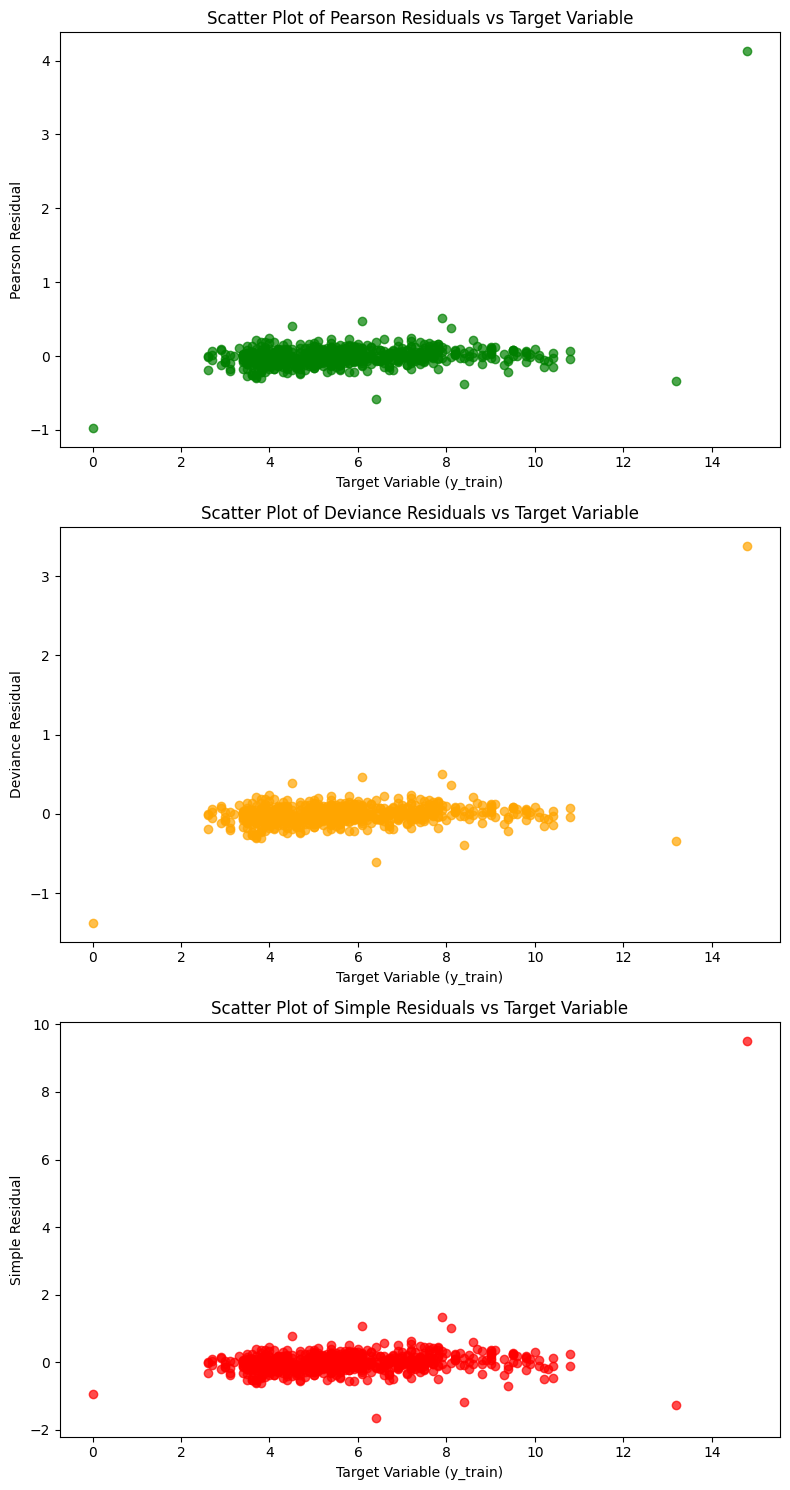

In [45]:
# Plot histogram and box plot styled scatter plot for residuals
fig, axs = plt.subplots(3, 1, figsize=(8, 15), gridspec_kw={'height_ratios': [1, 1, 1]})

# Scatter plot for Pearson residuals
axs[0].scatter(y=pearson_residuals, x=y_train, alpha=0.7, color="green")
axs[0].set_xlabel("Target Variable (y_train)")
axs[0].set_ylabel("Pearson Residual")
axs[0].set_title("Scatter Plot of Pearson Residuals vs Target Variable")

# Scatter plot for Deviance residuals
axs[1].scatter(y=deviance_residuals, x=y_train, alpha=0.7, color="orange")
axs[1].set_xlabel("Target Variable (y_train)")
axs[1].set_ylabel("Deviance Residual")
axs[1].set_title("Scatter Plot of Deviance Residuals vs Target Variable")

# Scatter plot for Simple residuals
axs[2].scatter(y=simple_residuals, x=y_train, alpha=0.7, color="red")
axs[2].set_xlabel("Target Variable (y_train)")
axs[2].set_ylabel("Simple Residual")
axs[2].set_title("Scatter Plot of Simple Residuals vs Target Variable")

plt.tight_layout()
plt.show()


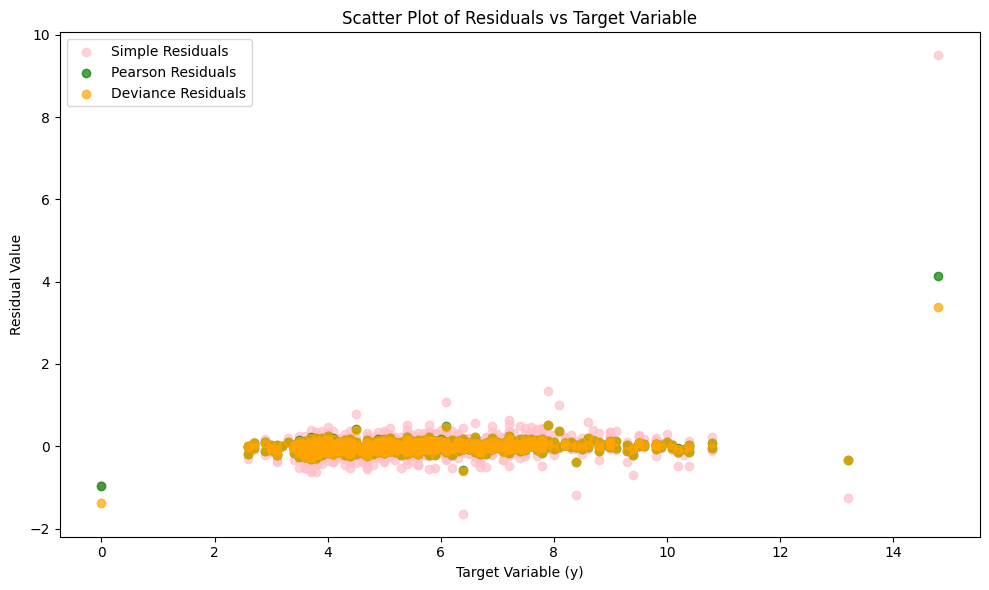

In [46]:
# Plot all residuals on the same graph with legends
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plots for each residual type

ax.scatter(y=simple_residuals, x=y_train, alpha=0.7, color="pink", label="Simple Residuals")
ax.scatter(y=pearson_residuals, x=y_train, alpha=0.7, color="green", label="Pearson Residuals")
ax.scatter(y=deviance_residuals, x=y_train, alpha=0.7, color="orange", label="Deviance Residuals")

# Add labels, title, and legend
ax.set_xlabel("Target Variable (y)")
ax.set_ylabel("Residual Value")
ax.set_title("Scatter Plot of Residuals vs Target Variable")
ax.legend()

plt.tight_layout()
plt.show()


# Predict December data


In [47]:
# Extract the last row for prediction
last_row = X_test.iloc[-1:].copy()

# Ensure final features include all expected features (excluding 'const' initially)
final_features_list = final_features if 'const' not in final_features else [f for f in final_features if f != 'const']

# Select the relevant features from the last row
last_row_features = last_row[final_features_list]

# Add the constant term to match the final model
last_row_const = sm.add_constant(last_row_features)


last_row_const['const'] = 1
print(last_row_const)
# Ensure the column alignment matches the model's parameters
last_row_const = last_row_const[final_model.params.index]

# Predict the 'Next Month Value' and calculate confidence intervals
prediction_results = final_model.get_prediction(last_row_const)
prediction_summary = prediction_results.summary_frame(alpha=0.05)  # 95% confidence interval

# Extract predicted value and confidence intervals
predicted_value = prediction_summary['mean'].iloc[0]
ci_lower = prediction_summary['mean_ci_lower'].iloc[0]
ci_upper = prediction_summary['mean_ci_upper'].iloc[0]

# Display results
print(f"Predicted 'Next Month Value' for the last row: {predicted_value}")
print(f"95% Confidence Interval: ({ci_lower}, {ci_upper})")


     CUUR0000SEHA    EXPGS  FEDFUNDS       GDI      GDP    DSPI  SP500   LFP  \
373          72.2  211.669     10.06  2501.832  2526.61  1750.9    0.0  63.8   

      EPR       EL       ClF   AWU  HLTHSCPCHCSA     UEL  Value  const  
373  60.1  98329.0  104502.0  11.2           0.0  6173.0    5.9      1  
Predicted 'Next Month Value' for the last row: 5.750382848396839
95% Confidence Interval: (5.665363476849191, 5.835402219944487)


In [48]:
ps = [1, 2, 3, 4, 5]
ds = [0]
qs = [0, 1, 2, 3]
# Modified ARIMA models with adjusted parameters
res = {}
models = {}
for p in ps:
  for d in ds:
    for q in qs:
      idea = ARIMA(train_ts, order=(p,d,q))
      model = idea.fit()
      forecast = model.forecast(steps=len(test_ts))
      mse = mean_squared_error(test_ts, forecast)
      res[f'{p}, {d}, {q}'] = mse
      models[f'{p}, {d}, {q}'] = model

arima_results_dict = {
    'Actual': test_ts.values,
}

for key in models:
  forecast = models[key].forecast(steps=len(test_ts))
  forecast.index = test_ts.index
  arima_results_dict[f'Predicted from {key}'] = forecast

arima_results = pd.DataFrame(arima_results_dict, index=test_ts.index)

display(arima_results)
fig_arima = go.Figure()
for col in arima_results.columns:
  fig_arima.add_trace(go.Scatter(x=arima_results.index, y=arima_results[col], mode='lines+markers', name=col))
fig_arima.add_trace(go.Scatter(x=X[train_size:].index, y=y_pred_lr, mode='lines+markers', name='Linear'))
fig_arima.update_layout(
    title='ARIMA Predictions vs Actual',
    xaxis_title='Date',
    yaxis_title='Value (Unemployment Rate)'
)
fig_arima.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so

,Actual,"Predicted from 1, 0, 0","Predicted from 1, 0, 1","Predicted from 1, 0, 2","Predicted from 1, 0, 3","Predicted from 2, 0, 0","Predicted from 2, 0, 1","Predicted from 2, 0, 2","Predicted from 2, 0, 3","Predicted from 3, 0, 0",...,"Predicted from 3, 0, 2","Predicted from 3, 0, 3","Predicted from 4, 0, 0","Predicted from 4, 0, 1","Predicted from 4, 0, 2","Predicted from 4, 0, 3","Predicted from 5, 0, 0","Predicted from 5, 0, 1","Predicted from 5, 0, 2","Predicted from 5, 0, 3"
DATE,,,,,,,,,,,,,,,,,,,,,
2009-07-01,9.6,9.475882,9.471240,9.473594,9.509186,9.469618,9.461521,9.585773,9.588656,9.482309,...,9.588385,9.606217,9.550808,9.589923,9.574691,9.569808,9.568249,9.595365,9.587656,9.559308
2009-08-01,9.8,9.451927,9.440822,9.419529,9.455692,9.435514,9.449483,9.589571,9.595233,9.432808,...,9.594785,9.625999,9.511655,9.598767,9.599177,9.550253,9.557266,9.607808,9.600265,9.546667
2009-09-01,10.0,9.428133,9.410661,9.377736,9.396500,9.401206,9.412258,9.562157,9.568063,9.375534,...,9.564100,9.613977,9.463835,9.583908,9.579252,9.472762,9.515549,9.595386,9.594525,9.457098
2009-10-01,9.9,9.404500,9.380756,9.336427,9.345748,9.367158,9.399697,9.508685,9.515197,9.308596,...,9.506946,9.580581,9.401087,9.545266,9.559426,9.340674,9.458200,9.566716,9.560468,9.345113
2009-11-01,9.9,9.381026,9.351103,9.295597,9.295711,9.333427,9.363660,9.433698,9.441214,9.239232,...,9.428800,9.525171,9.317681,9.483723,9.490438,9.172029,9.383218,9.521471,9.500628,9.173523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-01,4.2,6.973804,6.654298,6.262252,6.083055,6.489028,6.915008,5.702863,5.702093,5.814257,...,5.701959,5.679619,5.720467,5.702286,5.841515,5.680687,5.707761,5.967095,5.508697,5.403998
2024-08-01,4.1,6.966713,6.647703,6.257072,6.078998,6.482902,6.908014,5.702863,5.702093,5.812685,...,5.701959,5.679616,5.720317,5.702285,5.841515,5.680464,5.707746,5.967044,5.508699,5.403437
2024-09-01,4.1,6.959669,6.641164,6.251951,6.074997,6.476835,6.901023,5.702863,5.702093,5.811147,...,5.701959,5.679613,5.720173,5.702284,5.841513,5.680248,5.707732,5.966996,5.508700,5.402889


In [49]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
import pandas as pd

# Ensure DATE is a datetime object and sorted
data_imputed['DATE'] = pd.to_datetime(data_imputed['DATE'])
data_imputed = data_imputed.sort_values(by='DATE')

# Create the time series
value_series = data_imputed[['DATE', 'Next Month Value']].set_index('DATE')['Next Month Value']

# Split into training and testing sets
train_size = int(len(value_series) * 0.8)
train_ts, test_ts = value_series.iloc[:train_size], value_series.iloc[train_size:]

# Define ARIMA parameters
ps = [1, 2, 3, 4, 5]
ds = [0]
qs = [0, 1, 2, 3]

# Train ARIMA models and collect forecasts
res = {}
models = {}
for p in ps:
    for d in ds:
        for q in qs:
            idea = ARIMA(train_ts, order=(p, d, q))
            model = idea.fit()

            # Forecast and reindex to match the test period
            forecast = model.forecast(steps=len(test_ts))
            forecast.index = test_ts.index  # Ensure proper indexing

            # Collect MSE and models
            mse = mean_squared_error(test_ts, forecast)
            res[f'{p}, {d}, {q}'] = mse
            models[f'{p}, {d}, {q}'] = model

# Create a DataFrame for results
arima_results_dict = {'Actual': value_series[test_ts.index].values}

for key, model in models.items():
    # Generate forecast and reindex to match the full test set
    forecast = model.forecast(steps=len(test_ts))
    forecast.index = test_ts.index  # Use the test_ts index for alignment
    arima_results_dict[f'Predicted from {key}'] = forecast

arima_results = pd.DataFrame(arima_results_dict, index=test_ts.index)

# Ensure the ARIMA index covers the full date range
full_index = pd.date_range(start=value_series.index.min(), end=value_series.index.max(), freq='MS')  # Adjust freq as needed
arima_results = arima_results.reindex(full_index, method='nearest')  # Optional: Nearest or other interpolation

# Plot results
fig_arima = go.Figure()
for col in arima_results.columns:
    fig_arima.add_trace(go.Scatter(x=arima_results.index, y=arima_results[col], mode='lines+markers', name=col))

fig_arima.update_layout(
    title='ARIMA Predictions vs Actual',
    xaxis_title='Date',
    yaxis_title='Value (Unemployment Rate)'
)
fig_arima.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so

In [50]:
fig_arima = go.Figure()
for col in arima_results.columns:
  fig_arima.add_trace(go.Scatter(x=arima_results.index, y=arima_results[col], mode='lines+markers', name=col))
fig_arima.add_trace(go.Scatter(x=lr_results_back['DATE'], y=lr_results_back['Predicted'], mode='lines+markers', name='LR Backward Predicted'))
fig_arima.update_layout(
    title='ARIMA Predictions, LR Backward Predictions vs Actual',
    xaxis_title='Date',
    yaxis_title='Value (Unemployment Rate)'
)
fig_arima.show()

# Try using the same selected features on data after 2020 to get estimates, then predict December U3


In [94]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load data
data_imputed = pd.read_csv("Data Imputed.csv", index_col=0)

# Convert the 'DATE' column to datetime
data_imputed['DATE'] = pd.to_datetime(data_imputed['DATE'])

# Filter the data to include only rows where 'DATE' is after 2000-01-01
data_imputed = data_imputed[data_imputed['DATE'] > '2000-01-01']
display(data_imputed.head(5))

,DATE,Series ID,Year,Period,Label,Value,Next Month Value,CPIAUCSL,CUUR0000SEHA,EXPGS,...,SP500,LFP,EPR,EL,ClF,AWU,INDPRO,BOGZ1FA895050005Q,HLTHSCPCHCSA,UEL
625,2000-02-01,LNS14000000,2000,M02,2000 Feb,4.1,4.0,170.0,181.5,1052.904,...,0.0,67.3,64.6,136598.0,142456.0,12.6,91.7245,1.072429e+06,327.704293,5858.0
626,2000-03-01,LNS14000000,2000,M03,2000 Mar,4.0,3.8,171.0,182.0,1052.904,...,0.0,67.3,64.6,136701.0,142434.0,12.7,92.0830,1.072429e+06,327.704293,5733.0
627,2000-04-01,LNS14000000,2000,M04,2000 Apr,3.8,4.0,170.9,182.3,1093.360,...,0.0,67.3,64.7,137270.0,142751.0,12.4,92.6659,1.107012e+06,327.704293,5481.0
628,2000-05-01,LNS14000000,2000,M05,2000 May,4.0,4.0,171.2,182.7,1093.360,...,0.0,67.1,64.4,136630.0,142388.0,12.6,92.9347,1.107012e+06,327.704293,5758.0
629,2000-06-01,LNS14000000,2000,M06,2000 Jun,4.0,4.0,172.2,183.2,1093.360,...,0.0,67.1,64.5,136940.0,142591.0,12.3,93.0018,1.107012e+06,327.704293,5651.0


In [95]:
print(data_imputed.tail(2))
# See that there were some 0 not correctly imputed


          DATE    Series ID  Year Period     Label  Value  Next Month Value  \
921 2024-10-01  LNS14000000  2024    M10  2024 Oct    4.1               4.2   
922 2024-11-01  LNS14000000  2024    M11  2024 Nov    4.2               0.0   

     CPIAUCSL  CUUR0000SEHA  EXPGS  ...     SP500   LFP   EPR        EL  \
921   315.454       425.381    0.0  ...  6.184995  62.6  60.0  161496.0   
922     0.000         0.000    0.0  ...  6.206717  62.5  59.8  161141.0   

          ClF   AWU    INDPRO  BOGZ1FA895050005Q  HLTHSCPCHCSA     UEL  
921  168479.0  22.9  102.2805                0.0           0.0  6984.0  
922  168286.0  23.7    0.0000                0.0           0.0  7145.0  

[2 rows x 27 columns]


In [96]:
data_imputed = data_imputed.replace(0, np.nan).fillna(method='ffill').fillna(method='bfill')
display(data_imputed.tail(2)) # Now is correct

<ipython-input-96-658e0324372a>:1: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,DATE,Series ID,Year,Period,Label,Value,Next Month Value,CPIAUCSL,CUUR0000SEHA,EXPGS,...,SP500,LFP,EPR,EL,ClF,AWU,INDPRO,BOGZ1FA895050005Q,HLTHSCPCHCSA,UEL
921,2024-10-01,LNS14000000,2024,M10,2024 Oct,4.1,4.2,315.454,425.381,3210.729,...,6.184995,62.6,60.0,161496.0,168479.0,22.9,102.2805,2746836.0,774.890554,6984.0
922,2024-11-01,LNS14000000,2024,M11,2024 Nov,4.2,4.2,315.454,425.381,3210.729,...,6.206717,62.5,59.8,161141.0,168286.0,23.7,102.2805,2746836.0,774.890554,7145.0


In [97]:
last_row = data_imputed.tail(1).values.tolist()
columns = data_imputed.columns.to_list()

In [98]:

# Create a numeric date column
data_imputed['DATE_NUMERIC'] = (data_imputed['DATE'] - data_imputed['DATE'].min()).dt.days

# Replace '.' with NaN and drop missing values
data_imputed = data_imputed.replace('.', np.nan).dropna()

# Specify the selected features
feature_selected = ['CUUR0000SEHA', 'EXPGS', 'FEDFUNDS', 'GDI', 'GDP', 'DSPI',
                    'SP500', 'LFP', 'EPR', 'EL', 'ClF', 'AWU', 'HLTHSCPCHCSA',
                    'UEL', 'Value', 'DATE_NUMERIC']
outcome_var = 'Next Month Value'

# Ensure the data only includes the selected features
data_imputed = data_imputed[feature_selected + [outcome_var]]

# Convert feature columns to float
data_imputed[feature_selected] = data_imputed[feature_selected].astype(float)

# Define features (X) and target variable (y)
X = data_imputed[feature_selected]
y = data_imputed[outcome_var]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

# Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions and calculate MSE
y_pred_lr = linear_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)

# Output results
print("Mean Squared Error (Linear Regression):", mse_lr)


Mean Squared Error (Linear Regression): 0.06719074029701072


In [60]:
data_imputed.head(3)

,CUUR0000SEHA,EXPGS,FEDFUNDS,GDI,GDP,DSPI,SP500,LFP,EPR,EL,ClF,AWU,HLTHSCPCHCSA,UEL,Value,DATE_NUMERIC,Next Month Value
625,181.5,1052.904,5.73,10156.063,10002.179,7199.7,0.0,67.3,64.6,136598.0,142456.0,12.6,327.704293,5858.0,4.1,0.0,4.0
626,182.0,1052.904,5.85,10156.063,10002.179,7249.8,0.0,67.3,64.6,136701.0,142434.0,12.7,327.704293,5733.0,4.0,29.0,3.8
627,182.3,1093.360,6.02,10287.356,10247.720,7280.3,0.0,67.3,64.7,137270.0,142751.0,12.4,327.704293,5481.0,3.8,60.0,4.0


In [100]:
# Final model resulting parameter estimates
#final_model = sm.OLS(y_train, X_opt).fit()

# Filter X_test_const to include only the features in the final model
X_test_const = sm.add_constant(X_test[X_opt.columns[1:]])  # Exclude the 'const' from feature filtering


# Make predictions using the final model
y_pred_lr_back = linear_model.predict(X_test)

# Create a DataFrame with actual and predicted values
lr_results_back = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_lr_back
}).reset_index(drop=True)

# Display results
display(lr_results_back.head())


,Actual,Predicted
0,3.8,4.029675
1,3.9,3.952817
2,5.6,5.396063
3,5.9,6.119407
4,4.1,4.207661


In [101]:
# Ensure DATE_NUMERIC is back to proper datetime format for visualization
min_date = pd.to_datetime('2000-01-01')  # Reference minimum date
X_test['DATE'] = X_test['DATE_NUMERIC'].apply(lambda x: min_date + pd.Timedelta(days=x))

# Exclude the 'DATE' column before making predictions
X_test_features = X_test.drop(columns=['DATE'])

# Make predictions using the original model
y_pred_lr_back = linear_model.predict(X_test_features)

# Create a DataFrame with proper DATE, actual, and predicted values
lr_results_back = pd.DataFrame({
    'DATE': X_test['DATE'],  # Use proper datetime DATE column
    'Actual': y_test,
    'Predicted': y_pred_lr_back
}).sort_values(by='DATE').reset_index(drop=True)

# Plotting with DATE on the x-axis
import plotly.graph_objects as go

fig_lr = go.Figure()
fig_lr.add_trace(go.Scatter(x=lr_results_back['DATE'], y=lr_results_back['Actual'], mode='lines+markers', name='Actual'))
fig_lr.add_trace(go.Scatter(x=lr_results_back['DATE'], y=lr_results_back['Predicted'], mode='lines+markers', name='Predicted'))
fig_lr.update_layout(
    title='Linear Regression Predictions vs Actual',
    xaxis_title='Date',
    yaxis_title='Value (Unemployment Rate)',
    legend=dict(x=0.01, y=0.99),
    xaxis=dict(type='date')
)
fig_lr.show()


In [89]:
print(columns)

['DATE', 'Series ID', 'Year', 'Period', 'Label', 'Value', 'Next Month Value', 'CPIAUCSL', 'CUUR0000SEHA', 'EXPGS', 'IMPGS', 'FEDFUNDS', 'GDI', 'GDP', 'LFWA64TTUSM647S', 'GASREGW', 'DSPI', 'SP500', 'LFP', 'EPR', 'EL', 'ClF', 'AWU', 'INDPRO', 'BOGZ1FA895050005Q', 'HLTHSCPCHCSA', 'UEL']


In [91]:
print(last_row)
for val, col in zip(last_row[0],columns):
  print(f"{col}: {val}")

[[Timestamp('2024-11-01 00:00:00'), 'LNS14000000', 2024, 'M11', '2024 Nov', 4.2, 4.2, 315.454, 425.381, 3210.729, 4161.259, 4.64, 29114.0, 29354.321, 209089300.0, 6.53387782315193e-05, 21888.0, 6.206717226435536, 62.5, 59.8, 161141.0, 168286.0, 23.7, 102.2805, 2746836.0, 774.8905536316753, 7145.0]]
DATE: 2024-11-01 00:00:00
Series ID: LNS14000000
Year: 2024
Period: M11
Label: 2024 Nov
Value: 4.2
Next Month Value: 4.2
CPIAUCSL: 315.454
CUUR0000SEHA: 425.381
EXPGS: 3210.729
IMPGS: 4161.259
FEDFUNDS: 4.64
GDI: 29114.0
GDP: 29354.321
LFWA64TTUSM647S: 209089300.0
GASREGW: 6.53387782315193e-05
DSPI: 21888.0
SP500: 6.206717226435536
LFP: 62.5
EPR: 59.8
EL: 161141.0
ClF: 168286.0
AWU: 23.7
INDPRO: 102.2805
BOGZ1FA895050005Q: 2746836.0
HLTHSCPCHCSA: 774.8905536316753
UEL: 7145.0


In [105]:
# Reference minimum date
min_date = pd.to_datetime('2000-01-01')

# Assuming the last row corresponds to today's date
last_row_date = pd.Timestamp.today()  # Replace with the actual date if known
date_numeric = (last_row_date - min_date).days

# Add DATE_NUMERIC to the last row data
last_row_data = pd.DataFrame({
    'CUUR0000SEHA': [425.381],
    'EXPGS': [3210.729],
    'FEDFUNDS': [4.64],
    'GDI': [29114.0],
    'GDP': [29354.321],
    'DSPI': [21888.0],
    'SP500': [6.206717226435536],
    'LFP': [62.5],
    'EPR': [59.8],
    'EL': [161141.0],
    'ClF': [168286.0],
    'AWU': [23.7],
    'HLTHSCPCHCSA': [774.8905536316753],
    'UEL': [7145.0],
    'Value': [4.2],
    'DATE_NUMERIC': [date_numeric]  # Add calculated DATE_NUMERIC
})

# Ensure feature columns match the training set
last_row_features = last_row_data[feature_selected].values

# Predict the outcome using the linear model
last_row_prediction = linear_model.predict(last_row_features)

# Display the prediction
print("Prediction for the provided last row:", last_row_prediction[0])


Prediction for the provided last row: 4.466780402805767


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



In [103]:
print(X_train)

     CUUR0000SEHA     EXPGS  FEDFUNDS        GDI        GDP     DSPI  \
884       351.255  2570.103      0.08  23947.672  23921.991  18308.1   
758       252.145  2040.407      0.14  15358.947  15351.448  11744.3   
878       345.717  2381.224      0.07  22686.561  22656.793  21875.4   
795       274.100  2395.168      0.09  17652.741  17518.508  12870.0   
888       357.737  2848.698      0.08  25355.214  25215.491  18201.9   
..            ...       ...       ...        ...        ...      ...   
826       301.587  2268.339      0.41  18984.656  19089.379  14116.1   
793       272.733  2343.602      0.07  17313.351  17197.738  12708.5   
810       286.090  2260.724      0.13  18460.774  18401.626  13572.5   
660       203.300  1004.201      1.24  11245.795  11174.129   8268.0   
754       250.317  1972.116      0.19  15263.709  15309.474  11478.1   

        SP500   LFP   EPR        EL       ClF   AWU  HLTHSCPCHCSA      UEL  \
884  4.901506  61.7  58.8  153909.0  161568.0  28.5    77

In [106]:
import numpy as np

# Make prediction using the linear model
last_row_prediction = linear_model.predict(last_row_features)

# Calculate the standard error of prediction
# Get MSE (Mean Squared Error) from the test set
mse = mean_squared_error(y_test, y_pred_lr)

# Extract the coefficients and design matrix for the training set
X_train_matrix = np.array(X_train)

# Ensure last_row_features and X_train have matching shapes
X_last = np.array(last_row_features).reshape(-1)  # Flatten to 1D array
X_mean = X_train_matrix.mean(axis=0)  # Mean of the training data

# Align dimensions of X_last and X_mean
if X_last.shape[0] != X_mean.shape[0]:
    raise ValueError("Mismatch in feature dimensions. Check the input data.")

# Center the last row's features
X_centered = X_last - X_mean

# Calculate (X^T * X)^-1
inv_XTX = np.linalg.inv(X_train_matrix.T @ X_train_matrix)

# Calculate standard error
SE = np.sqrt(mse * (1 + X_centered @ inv_XTX @ X_centered.T))

# Calculate 95% confidence interval
lower_bound = last_row_prediction[0] - 1.96 * SE
upper_bound = last_row_prediction[0] + 1.96 * SE

# Display the results
print(f"Prediction: {last_row_prediction[0]:.4f}")
print(f"95% Confidence Interval: [{lower_bound:.4f}, {upper_bound:.4f}]")


Prediction: 4.4668
95% Confidence Interval: [3.9219, 5.0117]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

